# Code

In [ ]:
import pandas as pd
import re

# Load G-code from a file
gcode_path = r'C:\Users\arya\Desktop\MakeUC2024\KV_Challenge\Public Materials\KV_Monogram_Flat.gcode'
with open(gcode_path, 'r') as file:
    gcode_data = file.read()

def parse_gcode(gcode):
    # Split G-code into lines
    lines = gcode.strip().split('\n')
    
    # Initialize list to hold parsed data
    parsed_data = []
    
    # Regex pattern to match G-code commands and comments
    pattern = re.compile(r'([GMT]\d+)|([XYZIJRF]\-?\d+\.\d*)|(;.*)')
    
    # Loop through each line and parse it
    for line in lines:
        matches = pattern.findall(line)
        
        # Extract commands and parameters
        command = None
        parameters = {}
        comment = None
        
        for match in matches:
            if match[0]:
                command = match[0]  # G, M, or T command
            elif match[1]:
                key = match[1][0]
                value = float(match[1][1:])
                parameters[key] = value  # Coordinate or feed rate
            elif match[2]:
                comment = match[2][1:].strip()  # Comment without ';'
        
        # If the line is only a comment, add it to parsed data
        if command or parameters or comment:
            parsed_data.append({
                'Command': command,
                **parameters,
                'Comment': comment
            })
    
    # Convert parsed data to DataFrame
    df = pd.DataFrame(parsed_data)
    return df

# Parse the G-code from the file
df = parse_gcode(gcode_data)

# Display the DataFrame
print(df)

# If needed, you can also save the DataFrame to a CSV file
df.to_csv('parsed_gcode.csv', index=False)


      Command                                            Comment   X   Y   Z  \
0        None                                 HEADER_BLOCK_START NaN NaN NaN   
1        None                            BambuStudio 01.09.07.52 NaN NaN NaN   
2        None  model printing time: 1h 0m 17s; total estimate... NaN NaN NaN   
3        None                            total layer number: 100 NaN NaN NaN   
4        None              total filament length [mm] : 10784.01 NaN NaN NaN   
...       ...                                                ...  ..  ..  ..   
60117    None                =====printer finish  sound========= NaN NaN NaN   
60118    M400                                               None NaN NaN NaN   
60119     M18                                               None NaN NaN NaN   
60120     M73                                               None NaN NaN NaN   
60121    None                               EXECUTABLE_BLOCK_END NaN NaN NaN   

        R   F   I   J  
0     NaN NaN N

In [48]:
df.head()

Command                                            Comment   X   Y   Z   R  \
0    None                                 HEADER_BLOCK_START NaN NaN NaN NaN   
1    None                            BambuStudio 01.09.07.52 NaN NaN NaN NaN   
2    None  model printing time: 1h 0m 17s; total estimate... NaN NaN NaN NaN   
3    None                            total layer number: 100 NaN NaN NaN NaN   
4    None              total filament length [mm] : 10784.01 NaN NaN NaN NaN   

    F   I   J  
0 NaN NaN NaN  
1 NaN NaN NaN  
2 NaN NaN NaN  
3 NaN NaN NaN  
4 NaN NaN NaN

In [53]:
print(df["Command"].unique())


[None 'M73' 'M201' 'M203' 'T20000' 'M205' 'M106' 'M1002' 'M104' 'M140'
 'G392' 'M9833' 'M17' 'M400' 'M1006' 'M100' 'M18' 'G91' 'G380' 'G1' 'G90'
 'M204' 'M630' 'M960' 'M83' 'M220' 'M221' 'M982' 'M109' 'G28' 'M211'
 'M975' 'M620' 'T0' 'T240' 'G92' 'M621' 'G0' 'T300' 'G29' 'M622' 'G39'
 'M623' 'M970' 'M974' 'M20' 'G2' 'M190' 'M500' 'T145' 'T1000' 'M412' 'M1'
 'M983' 'M984' 'M1007' 'G21' 'M981' 'M991' 'G17' 'M971' 'G3' 'M1003'
 'T255']


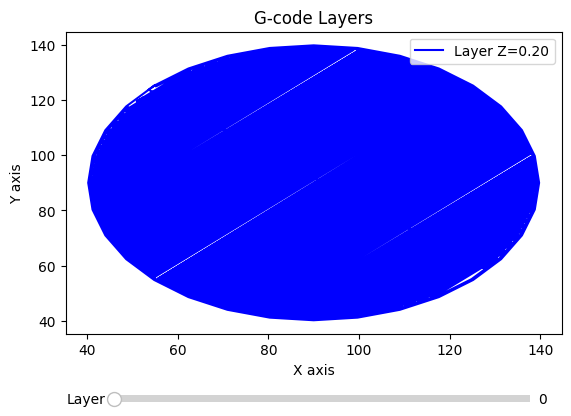

In [40]:
import re
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from shapely.geometry import Polygon, MultiPolygon
from shapely.geometry.polygon import orient

def parse_gcode_layers(file_path):
    """
    Parses G-code to extract X, Y, Z coordinates and organize them by layers (Z levels).
    """
    layers = defaultdict(list)
    current_z = None
    
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith("G1"):  # Typically the command for linear movement
                # Extract X, Y, Z values
                x_match = re.search(r'X([-\d.]+)', line)
                y_match = re.search(r'Y([-\d.]+)', line)
                z_match = re.search(r'Z([-\d.]+)', line)
                
                x = float(x_match.group(1)) if x_match else None
                y = float(y_match.group(1)) if y_match else None
                z = float(z_match.group(1)) if z_match else current_z

                if z is not None:
                    current_z = z
                
                if x is not None and y is not None:
                    layers[current_z].append((x, y))
    
    return layers

def visualize_layers_with_slider(layers):
    """
    Visualizes each layer's path using matplotlib, with a slider to scroll through layers.
    """
    sorted_heights = sorted(layers.keys())
    initial_z = sorted_heights[0]

    fig, ax = plt.subplots()
    plt.subplots_adjust(bottom=0.25)
    
    # Plot the initial layer
    layer_data = layers[initial_z]
    layer_plot, = plt.plot(*zip(*layer_data), label=f'Layer Z={initial_z:.2f}', color='b')
    plt.xlabel('X axis')
    plt.ylabel('Y axis')
    plt.title('G-code Layers')
    plt.legend(loc='upper right')

    # Slider setup
    ax_slider = plt.axes([0.2, 0.1, 0.65, 0.03], facecolor='lightgoldenrodyellow')
    slider = Slider(ax_slider, 'Layer', 0, len(sorted_heights) - 1, valinit=0, valstep=1)

    def update(val):
        index = int(slider.val)
        z = sorted_heights[index]
        layer_data = layers[z]

        if layer_data:  # Ensure layer_data is not empty
            # Update plot with the new layer data
            layer_plot.set_data(*zip(*layer_data))
            layer_plot.set_label(f'Layer Z={z:.2f}')
            ax.relim()  # Recompute the limits of the axes
            ax.autoscale_view()  # Autoscale to the new data
            ax.legend(loc='upper right')
            fig.canvas.draw_idle()  # Redraw the canvas

    slider.on_changed(update)

    plt.show()

# Usage example
gcode_path = r'C:\Users\arya\Desktop\MakeUC2024\KV_Challenge\Public Materials\KV_Monogram_Flat.gcode'

# Step 1: Parse G-code into layers
layers = parse_gcode_layers(gcode_path)

# Step 2: Visualize the layers with a slider
visualize_layers_with_slider(layers)


In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from matplotlib.collections import LineCollection
import re

# Load G-code from a file
gcode_path = r'C:\Users\arya\Desktop\MakeUC2024\KV_Challenge\Public Materials\KV_Monogram_Flat.gcode'
with open(gcode_path, 'r') as file:
    gcode_data = file.readlines()

# Pre-process the G-code to remove unwanted sections
def preprocess_gcode(gcode_lines):
    filtered_lines = []
    removing = False
    wipe_removing = False
    layer_removing = False

    # Loop through each line and decide whether to keep or remove
    for i, line in enumerate(gcode_lines):
        print(f"Processing line {i}: {line.strip()}")  # Debugging: Print current line

        if "; don't support timelapse gcode in spiral_mode and by object sequence for I3 structure printer" in line:
            removing = True  # Start removing lines after this point
            print(f"Start removing due to timelapse section at line {i}")
        elif removing and line.startswith("; FEATURE:"):
            removing = False  # Stop removing lines when this pattern is encountered
            print(f"Stop removing due to FEATURE section at line {i}")

        if "; WIPE_START" in line:
            wipe_removing = True  # Start removing wipe section
            print(f"Start removing wipe section at line {i}")
        elif wipe_removing and "; WIPE_END" in line:
            wipe_removing = False  # Stop removing wipe section
            print(f"Stop removing wipe section at line {i}")
            continue  # Skip the WIPE_END line itself

        if "; CHANGE_LAYER" in line:
            layer_removing = True  # Start removing layer change section
            print(f"Start removing layer change section at line {i}")
        elif layer_removing and line.startswith("; FEATURE:"):
            layer_removing = False  # Stop removing layer change section
            print(f"Stop removing layer change section at line {i}")

        if not removing and not wipe_removing and not layer_removing:
            filtered_lines.append(line)
            print(f"Keeping line {i}: {line.strip()}")  # Debugging: Print line that is kept

    return filtered_lines

# Pre-process the G-code to remove unwanted parts
filtered_gcode_lines = preprocess_gcode(gcode_data)

# Convert filtered lines back to a single string
filtered_gcode = ''.join(filtered_gcode_lines)

# Parse the filtered G-code
def parse_gcode(gcode):
    # Split G-code into lines
    lines = gcode.strip().split('\n')
    
    # Initialize list to hold parsed data
    parsed_data = []
    
    # Regex pattern to match G-code commands and comments
    pattern = re.compile(r'([GMT]\d+)|([XYZIJRF]\-?\d+\.\d*)|(;.*)')
    
    # Loop through each line and parse it
    for line in lines:
        matches = pattern.findall(line)
        
        # Extract commands and parameters
        command = None
        parameters = {}
        comment = None
        
        for match in matches:
            if match[0]:
                command = match[0]  # G, M, or T command
            elif match[1]:
                key = match[1][0]
                value = float(match[1][1:])
                parameters[key] = value  # Coordinate or feed rate
            elif match[2]:
                comment = match[2][1:].strip()  # Comment without ';'
        
        # If the line is only a comment, add it to parsed data
        if command or parameters or comment:
            parsed_data.append({
                'Command': command,
                **parameters,
                'Comment': comment
            })
    
    # Convert parsed data to DataFrame
    df = pd.DataFrame(parsed_data)
    return df

# Parse the G-code from the filtered data
gcode_dataframe = parse_gcode(filtered_gcode)

Processing line 0: ; HEADER_BLOCK_START
Keeping line 0: ; HEADER_BLOCK_START
Processing line 1: ; BambuStudio 01.09.07.52
Keeping line 1: ; BambuStudio 01.09.07.52
Processing line 2: ; model printing time: 1h 0m 17s; total estimated time: 1h 5m 51s
Keeping line 2: ; model printing time: 1h 0m 17s; total estimated time: 1h 5m 51s
Processing line 3: ; total layer number: 100
Keeping line 3: ; total layer number: 100
Processing line 4: ; total filament length [mm] : 10784.01
Keeping line 4: ; total filament length [mm] : 10784.01
Processing line 5: ; total filament volume [cm^3] : 25938.59
Keeping line 5: ; total filament volume [cm^3] : 25938.59
Processing line 6: ; total filament weight [g] : 32.16
Keeping line 6: ; total filament weight [g] : 32.16
Processing line 7: ; filament_density: 1.24
Keeping line 7: ; filament_density: 1.24
Processing line 8: ; filament_diameter: 1.75
Keeping line 8: ; filament_diameter: 1.75
Processing line 9: ; max_z_height: 20.00
Keeping line 9: ; max_z_heig

In [52]:
def parse_gcode(file_path):
    feature_dict = {}
    current_feature = None

    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line.startswith('; FEATURE:'):
                # Extract the feature name after "; FEATURE: "
                current_feature = line.split(': ')[1]
            elif line.startswith('; LINE_WIDTH:') and current_feature:
                # Extract the line width after "; LINE_WIDTH: "
                line_width = float(line.split(': ')[1])
                # Map the current feature to its line width
                feature_dict[current_feature] = line_width

    return feature_dict

# Example usage
file_path = r'C:\Users\arya\Desktop\MakeUC2024\KV_Challenge\Public Materials\KV_Monogram_Flat.gcode'
feature_width_dict = parse_gcode(file_path)
print(feature_width_dict)


{'Inner wall': 0.45, 'Bottom surface': 0.502067, 'Outer wall': 0.42, 'Internal solid infill': 0.421345, 'Sparse infill': 0.45, 'Bridge': 0.400011, 'Top surface': 0.42, 'Gap infill': 0.110101}


In [62]:
!python "C:/Users/arya/Desktop/MakeUC2024/Gcode-Reader-KV/src/gcode_reader.py" -t 1 "C:/Users/arya/Desktop/MakeUC2024/KV_Challenge/Public Materials/KV_Monogram_Flat.gcode" -p


Gcode Reader
Handling M command: M73
Handling M command: M201
Handling M command: M203
Handling M command: M204
Handling T command: T20000
Handling M command: M205
Handling M command: M106
Handling M command: M106
Handling M command: M1002
Handling M command: M1002
Handling M command: M104
Handling M command: M140
Handling M command: M9833.2
Handling M command: M17
Handling M command: M400
Handling M command: M1006
Handling M command: M1006
Handling M command: M100
Handling M command: M1006
Handling M command: M100
Handling M command: M1006
Handling M command: M100
Handling M command: M1006
Handling M command: M100
Handling M command: M1006
Handling M command: M100
Handling M command: M1006
Handling M command: M100
Handling M command: M1006
Handling M command: M100
Handling M command: M1006
Handling M command: M100
Handling M command: M1006
Handling M command: M100
Handling M command: M1006
Handling M command: M100
Handling M command: M1006
Handling M command: M100
Handling M command: 

In [133]:
import collections
from enum import Enum
import math
import os.path
import pprint
import statistics
import sys
import tempfile
import numpy as np
from stl import mesh
from collections import defaultdict
# third party library
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# maximum element length in meshing
MAX_ELEMENT_LENGTH = 1 # FDM regular

# set true to add axis-label and title
FIG_INFO = False

# MARGIN RATIO
MARGIN_RATIO = 0.2

class LayerError(Exception):
    """ layer number error """
    pass

class GcodeType(Enum):
    """ enum of GcodeType """
    FDM_REGULAR = 1
    FDM_STRATASYS = 2
    LPBF_REGULAR = 3
    LPBF_SCODE = 4

    @classmethod
    def has_value(cls, value):
        return any(value == item.value for item in cls)

class GcodeReader:
    def __init__(self, filename, filetype=GcodeType.FDM_REGULAR):
        if not os.path.exists(filename):
            print("{} does not exist!".format(filename))
            sys.exit(1)
        self.filename = filename
        self.filetype = filetype
        self.n_segs = 0  # number of line segments
        self.segs = None  # list of line segments [(x0, y0, x1, y1, z, e, segment_id)]
        self.n_layers = 0  # number of layers
        self.seg_index_bars = []
        self.subpath_index_bars = []
        self.summary = None
        self.lengths = None
        self.subpaths = None
        self.xyzlimits = None
        self.current_e = 0  # Track current E position
        self.is_absolute_e = True  # Track if E is absolute or relative
        self._read()

    def _read(self):
        """read the file and populate variables"""
        if self.filetype == GcodeType.FDM_REGULAR:
            self._read_fdm_regular()
        else:
            print("file type is not supported")
            sys.exit(1)
        self.xyzlimits = self._compute_xyzlimits(self.segs)

    def _compute_xyzlimits(self, seg_list):
        """compute axis limits of a segments list"""
        xmin, xmax = float('inf'), -float('inf')
        ymin, ymax = float('inf'), -float('inf')
        zmin, zmax = float('inf'), -float('inf')
        for x0, y0, x1, y1, z, e, _ in seg_list:  # Updated to handle 7 elements
            xmin = min(x0, x1) if min(x0, x1) < xmin else xmin
            ymin = min(y0, y1) if min(y0, y1) < ymin else ymin
            zmin = z if z < zmin else zmin
            xmax = max(x0, x1) if max(x0, x1) > xmax else xmax
            ymax = max(y0, y1) if max(y0, y1) > ymax else ymax
            zmax = z if z > zmax else zmax
        return (xmin, xmax, ymin, ymax, zmin, zmax)

    def _read_fdm_regular(self):
        """read FDM regular gcode type"""
        with open(self.filename, 'r') as infile:
            lines = (line.strip() for line in infile.readlines() if line.strip())
            new_lines = []
            for line in lines:
                if line.startswith(('G', 'M', 'T')):
                    idx = line.find(';')
                    if idx != -1:
                        line = line[:idx]
                    new_lines.append(line)
            lines = new_lines

        self.segs = []
        temp = -float('inf')
        gxyzef = [temp, temp, temp, temp, temp, temp, temp, temp]
        d = {'G': 0, 'X': 1, 'Y': 2, 'Z': 3, 'E': 4, 'F': 5, 'M': 6, 'T': 7}
        seg_count = 0
        mx_z = -math.inf
        last_e = 0
        e_relative_mode = False
        current_segment_id = 0
        last_was_extruding = False
        last_x = None
        last_y = None

        for line in lines:
            old_gxyzef = gxyzef[:]
            
            if "G91" in line:
                e_relative_mode = True
                continue
            elif "G90" in line:
                e_relative_mode = False
                continue
            elif "M83" in line:
                e_relative_mode = True
                continue
            elif "M82" in line:
                e_relative_mode = False
                continue

            for token in line.split():
                command_type = token[0]
                if command_type in d:
                    try:
                        if command_type in ['G', 'X', 'Y', 'Z', 'E', 'F']:
                            gxyzef[d[command_type]] = float(token[1:])
                        elif command_type in ['M', 'T']:
                            gxyzef[d[command_type]] = int(token[1:])
                    except ValueError:
                        print(f"Warning: Could not convert token '{token}'")

            if gxyzef[4] != temp:
                if e_relative_mode:
                    e_movement = gxyzef[4]
                    last_e += e_movement
                else:
                    e_movement = gxyzef[4] - last_e
                    last_e = gxyzef[4]
            else:
                e_movement = 0

            is_extruding = e_movement > 0
            
            # Check for discontinuity
            current_x = gxyzef[1] if gxyzef[1] != temp else last_x
            current_y = gxyzef[2] if gxyzef[2] != temp else last_y
            
            if last_x is not None and last_y is not None:
                is_discontinuous = (abs(current_x - last_x) > 0.01 or 
                                 abs(current_y - last_y) > 0.01)
            else:
                is_discontinuous = False
            
            # Increment segment ID for new extrusion paths or discontinuities
            if ((is_extruding != last_was_extruding and is_extruding) or 
                (is_extruding and is_discontinuous)):
                current_segment_id += 1
            
            last_was_extruding = is_extruding
            last_x = current_x
            last_y = current_y

            if (gxyzef[0] in [0, 1, 2, 3] and gxyzef[1:3] != old_gxyzef[1:3]):
                if gxyzef[3] > mx_z:
                    mx_z = gxyzef[3]
                    self.n_layers += 1
                    self.seg_index_bars.append(seg_count)

                x0, y0, z = old_gxyzef[1:4]
                x1, y1 = gxyzef[1:3]
                self.segs.append((x0, y0, x1, y1, z, is_extruding, current_segment_id))
                seg_count += 1

        self.n_segs = len(self.segs)
        self.segs = np.array(self.segs)
        self.seg_index_bars.append(self.n_segs)
        assert(len(self.seg_index_bars) - self.n_layers == 1)

    def create_axis(self, figsize=(8, 8), projection='2d'):
        """create axis based on figure size and projection"""
        projection = projection.lower()
        if projection not in ['2d', '3d']:
            raise ValueError
        if projection == '2d':
            fig, ax = plt.subplots(figsize=figsize)
        else:  # '3d'
            fig = plt.figure(figsize=figsize)
            ax = fig.add_subplot(111, projection='3d')
        return fig, ax

    def save_figure(self, fig, filename, dpi=200):
        """save figure to a file"""
        _, ext = os.path.splitext(filename)
        ext = ext[1:]  # Remove the dot
        fig.savefig(filename, format=ext, dpi=dpi, bbox_inches='tight')
        print('saving to {:s} with {:d} DPI'.format(filename, dpi))

    def _compute_subpaths(self):
        """compute subpaths with segment IDs"""
        if not self.subpaths:
            self.subpaths = []
            self.subpath_index_bars = [0]
            x0, y0, x1, y1, z, e, seg_id = self.segs[0, :]
            xs, ys, zs, es, seg_ids = [x0, x1], [y0, y1], [z, z], [e, e], [seg_id, seg_id]
            mx_z = zs[-1]
            for x0, y0, x1, y1, z, e, seg_id in self.segs[1:, :]:
                if x0 != xs[-1] or y0 != ys[-1] or z != zs[-1]:
                    self.subpaths.append((xs, ys, zs, es, seg_ids))
                    if z > mx_z:
                        mx_z = z
                        self.subpath_index_bars.append(len(self.subpaths))
                    xs, ys, zs, es, seg_ids = [x0, x1], [y0, y1], [z, z], [e, e], [seg_id, seg_id]
                else:
                    xs.append(x1)
                    ys.append(y1)
                    zs.append(z)
                    es.append(e)
                    seg_ids.append(seg_id)
            if len(xs) != 0:
                self.subpaths.append((xs, ys, zs, es, seg_ids))
            self.subpath_index_bars.append(len(self.subpaths))

    def plot_layers_to_png(self, min_layer, max_layer=None, temp_dir=None):
        """Generate and save PNGs of each layer with segment coloring"""
        if max_layer is None:
            max_layer = self.n_layers + 1
        if (min_layer >= max_layer or min_layer < 1 or max_layer > self.n_layers + 1):
            raise LayerError("Layer number is invalid!")

        if temp_dir is None:
            temp_dir = tempfile.mkdtemp()

        self._compute_subpaths()

        for layer in range(min_layer, max_layer):
            fig, ax = self.create_axis(projection='2d')
            left, right = (self.subpath_index_bars[layer - 1],
                          self.subpath_index_bars[layer])
            
            # Create a colormap for segments
            unique_segments = set()
            for subpath in self.subpaths[left:right]:
                unique_segments.update(subpath[4])  # seg_ids
            colormap = plt.cm.get_cmap('tab20')(np.linspace(0, 1, len(unique_segments)))
            color_dict = dict(zip(sorted(unique_segments), colormap))
            
            for xs, ys, _, es, seg_ids in self.subpaths[left:right]:
                for i in range(len(xs)-1):
                    if es[i]:  # If extruding
                        color = color_dict[seg_ids[i]]
                    else:
                        color = 'lightgray'  # Non-extruding moves
                    ax.plot(xs[i:i+2], ys[i:i+2], color=color, alpha=0.7 if es[i] else 0.3)

            ax.axis('equal')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.axis('off')

            outfile = os.path.join(temp_dir, f"layer_{layer:03d}.png")
            self.save_figure(fig, outfile, dpi=200)
            plt.close(fig)
        print(f"Saved all layer PNGs to: {temp_dir}")

    def plot(self, ax=None):
        """plot the whole part in 3D with segment coloring"""
        if not ax:
            fig, ax = self.create_axis(projection='3d')
        assert(self.n_segs > 0)
        self._compute_subpaths()
        
        # Create a colormap for segments
        unique_segments = set()
        for subpath in self.subpaths:
            unique_segments.update(subpath[4])  # seg_ids
        colormap = plt.cm.get_cmap('tab20')(np.linspace(0, 1, len(unique_segments)))
        color_dict = dict(zip(sorted(unique_segments), colormap))
        
        for xs, ys, zs, es, seg_ids in self.subpaths:
            for i in range(len(xs)-1):
                if es[i]:  # If extruding
                    color = color_dict[seg_ids[i]]
                else:
                    color = 'lightgray'  # Non-extruding moves
                ax.plot(xs[i:i+2], ys[i:i+2], zs[i:i+2], 
                       color=color, alpha=0.7 if es[i] else 0.3)
        
        xmin, xmax, ymin, ymax, _, _ = self.xyzlimits
        ax.set_xlim(add_margin_to_axis_limits(xmin, xmax))
        ax.set_ylim(add_margin_to_axis_limits(ymin, ymax))
        return fig, ax

    def generate_3d_dataframe(self):
        """Generate a dataframe of all 3D path data with extrusion status and segment IDs"""
        self._compute_subpaths()
        data = []
        for xs, ys, zs, es, seg_ids in self.subpaths:
            for x, y, z, e, seg_id in zip(xs, ys, zs, es, seg_ids):
                data.append({
                    'X': x,
                    'Y': y,
                    'Z': z,
                    'E': bool(e),
                    'segment_id': int(seg_id)
                })
        return pd.DataFrame(data)
    def _create_extrusion_mesh(self, width=0.4, height=0.2):
        """Convert extrusion paths into triangulated mesh data"""
        vertices = []
        faces = []
        vertex_count = 0
        
        # Group segments by layer
        layer_segments = defaultdict(list)
        for x0, y0, x1, y1, z, is_extruding, seg_id in self.segs:
            if is_extruding:  # Only process extrusion moves
                layer_segments[z].append((x0, y0, x1, y1))

        # Process each layer
        for z, segments in layer_segments.items():
            for x0, y0, x1, y1 in segments:
                # Calculate segment direction and perpendicular
                dx = x1 - x0
                dy = y1 - y0
                length = np.sqrt(dx*dx + dy*dy)
                if length < 1e-6:  # Skip tiny segments
                    continue
                    
                # Unit vector perpendicular to segment
                nx = -dy / length * width/2
                ny = dx / length * width/2

                # Create vertices for the segment (rectangular prism)
                segment_vertices = [
                    # Bottom vertices
                    [x0 - nx, y0 - ny, z],
                    [x0 + nx, y0 + ny, z],
                    [x1 + nx, y1 + ny, z],
                    [x1 - nx, y1 - ny, z],
                    # Top vertices
                    [x0 - nx, y0 - ny, z + height],
                    [x0 + nx, y0 + ny, z + height],
                    [x1 + nx, y1 + ny, z + height],
                    [x1 - nx, y1 - ny, z + height],
                ]
                vertices.extend(segment_vertices)

                # Define triangles for this segment using vertex indices
                segment_faces = [
                    # Bottom face
                    [vertex_count + 0, vertex_count + 1, vertex_count + 2],
                    [vertex_count + 0, vertex_count + 2, vertex_count + 3],
                    # Top face
                    [vertex_count + 4, vertex_count + 6, vertex_count + 5],
                    [vertex_count + 4, vertex_count + 7, vertex_count + 6],
                    # Side faces
                    [vertex_count + 0, vertex_count + 4, vertex_count + 1],
                    [vertex_count + 1, vertex_count + 4, vertex_count + 5],
                    [vertex_count + 1, vertex_count + 5, vertex_count + 2],
                    [vertex_count + 2, vertex_count + 5, vertex_count + 6],
                    [vertex_count + 2, vertex_count + 6, vertex_count + 3],
                    [vertex_count + 3, vertex_count + 6, vertex_count + 7],
                    [vertex_count + 3, vertex_count + 7, vertex_count + 0],
                    [vertex_count + 0, vertex_count + 7, vertex_count + 4],
                ]
                faces.extend(segment_faces)
                vertex_count += 8

        return np.array(vertices), np.array(faces)

    def save_to_stl(self, filename, extrusion_width=0.4, layer_height=0.2):
        """Save the G-code paths as an STL file"""
        print("Generating triangulated mesh...")
        
        # Generate vertices and faces for all extrusion paths
        vertices, faces = self._create_extrusion_mesh(width=extrusion_width, height=layer_height)
        
        if len(faces) == 0:
            print("No extrusion paths found to create STL")
            return

        # Create the mesh
        print(f"Creating STL mesh with {len(vertices)} vertices and {len(faces)} faces...")
        
        # Initialize the mesh
        stl_mesh = mesh.Mesh(np.zeros(len(faces), dtype=mesh.Mesh.dtype))
        
        # Add faces to mesh
        for i, face in enumerate(faces):
            for j in range(3):
                stl_mesh.vectors[i][j] = vertices[face[j]]
        
        # Save the mesh to file
        print(f"Saving STL to {filename}...")
        stl_mesh.save(filename)
        print("STL file saved successfully.")

    def run_all(self, temp_dir=None, stl_output=None):
        """Run all tasks: plot layers to PNG and optionally save STL"""
        print("Running all tasks...")
        
        if temp_dir:
            self.plot_layers_to_png(min_layer=1, max_layer=self.n_layers + 1, temp_dir=temp_dir)
        
        if stl_output:
            self.save_to_stl(stl_output)
            print(f"STL file saved to: {stl_output}")
        
        print("All tasks completed.")

def add_margin_to_axis_limits(min_v, max_v, margin_ratio=MARGIN_RATIO):
    """compute new min_v and max_v based on margin"""
    dv = (max_v - min_v) * margin_ratio
    return (min_v - dv, max_v + dv)

In [134]:
# Create output directory
output_dir = "path/to/output"
os.makedirs(output_dir, exist_ok=True)

# Create reader instance
gcode_reader = GcodeReader(filename=r"C:\Users\arya\Desktop\MakeUC2024\KV_Challenge\Public Materials\KV_Monogram_Flat.gcode", filetype=GcodeType.FDM_REGULAR)

# Run analysis and save STL
gcode_reader.run_all(
    temp_dir=output_dir,
    stl_output="output.stl"
)

Running all tasks...
saving to path/to/output\layer_001.png with 200 DPI


C:\Users\arya\AppData\Local\Temp\ipykernel_24128\629663523.py:249: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap('tab20')(np.linspace(0, 1, len(unique_segments)))


saving to path/to/output\layer_002.png with 200 DPI
saving to path/to/output\layer_003.png with 200 DPI
saving to path/to/output\layer_004.png with 200 DPI
saving to path/to/output\layer_005.png with 200 DPI
saving to path/to/output\layer_006.png with 200 DPI
saving to path/to/output\layer_007.png with 200 DPI
saving to path/to/output\layer_008.png with 200 DPI
saving to path/to/output\layer_009.png with 200 DPI
saving to path/to/output\layer_010.png with 200 DPI
saving to path/to/output\layer_011.png with 200 DPI
saving to path/to/output\layer_012.png with 200 DPI
saving to path/to/output\layer_013.png with 200 DPI
saving to path/to/output\layer_014.png with 200 DPI
saving to path/to/output\layer_015.png with 200 DPI
saving to path/to/output\layer_016.png with 200 DPI
saving to path/to/output\layer_017.png with 200 DPI
saving to path/to/output\layer_018.png with 200 DPI
saving to path/to/output\layer_019.png with 200 DPI
saving to path/to/output\layer_020.png with 200 DPI
saving to pa

In [126]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46479 entries, 0 to 46478
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   X           46479 non-null  float64
 1   Y           46479 non-null  float64
 2   Z           46479 non-null  float64
 3   E           46479 non-null  bool   
 4   segment_id  46479 non-null  int64  
dtypes: bool(1), float64(3), int64(1)
memory usage: 1.5 MB
None


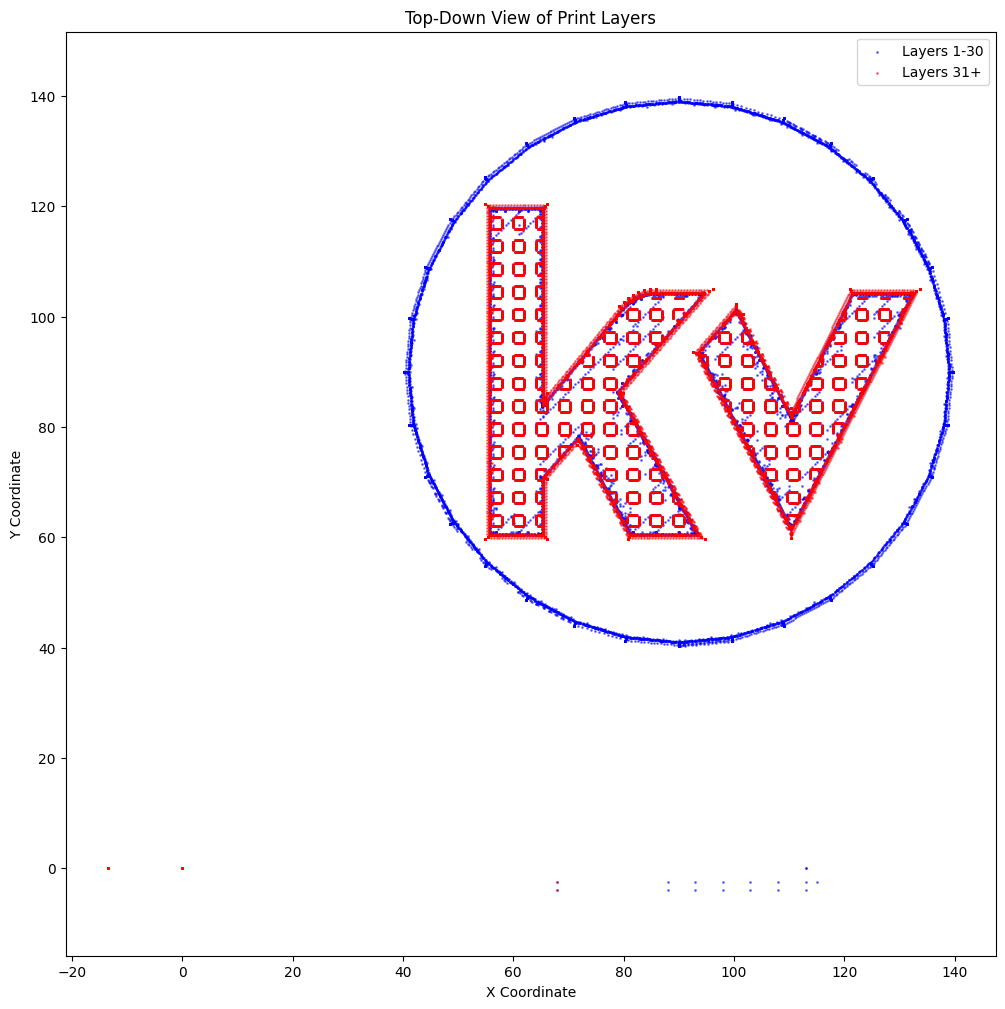

Total layers: 102
Points in layers 1-30: 16041
Points in layers 31+: 27005


In [127]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_top_down_layers(df):
    """
    Plot a top-down (2D) view of the print, with layers 1-30 in blue and the rest in red.
    Only shows points where extrusion is happening (E=True).
    
    Args:
        df: DataFrame containing columns 'X', 'Y', 'Z', 'E'.
    """
    # Check if dataframe has the required columns
    if not all(col in df.columns for col in ['X', 'Y', 'Z', 'E']):
        raise ValueError("Dataframe must contain 'X', 'Y', 'Z', and 'E' columns")
    
    # Filter for extrusion points only
    extrusion_df = df[df['E'] == True].copy()
    
    # Find unique Z values and sort them to determine layer numbers
    unique_z = sorted(extrusion_df['Z'].unique())
    
    # Create a layer number mapping
    z_to_layer = {z: i+1 for i, z in enumerate(unique_z)}
    extrusion_df['Layer'] = extrusion_df['Z'].map(z_to_layer)
    
    # Create figure
    plt.figure(figsize=(12, 12))
    
    # Split data by layer ranges
    early_layers = extrusion_df[extrusion_df['Layer'] <= 30]
    later_layers = extrusion_df[extrusion_df['Layer'] > 30]
    
    # Plot points
    plt.scatter(early_layers['X'], early_layers['Y'], 
               c='blue', s=1, label='Layers 1-30', alpha=0.5)
    plt.scatter(later_layers['X'], later_layers['Y'], 
               c='red', s=1, label='Layers 31+', alpha=0.5)
    
    # Set labels and title
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Top-Down View of Print Layers')
    
    # Make axes equal to preserve aspect ratio
    plt.axis('equal')
    
    # Add legend
    plt.legend()
    
    # Show plot
    plt.show()
    
    # Print some statistics
    print(f"Total layers: {len(unique_z)}")
    print(f"Points in layers 1-30: {len(early_layers)}")
    print(f"Points in layers 31+: {len(later_layers)}")

# Use the function
plot_top_down_layers(df)

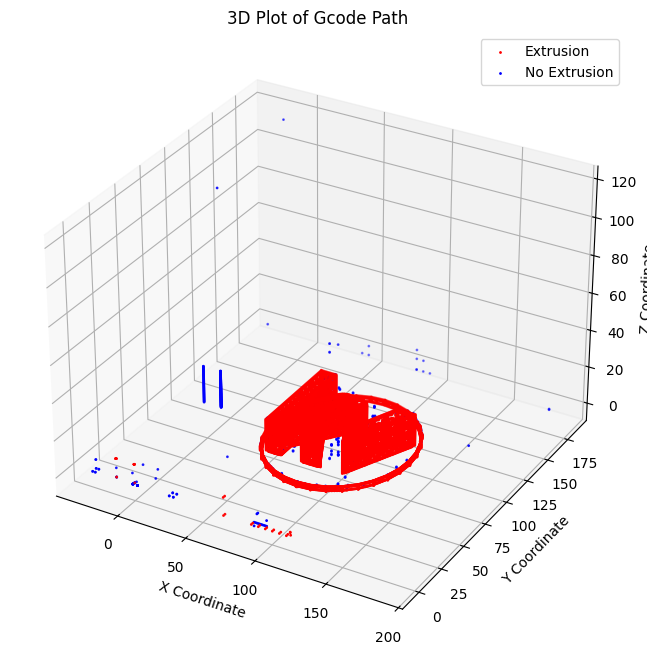

In [125]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

def plot_3d_dataframe(df):
    """
    Plot a 3D scatter plot from a dataframe containing X, Y, Z coordinates and extrusion status.
    Red points indicate extrusion (E=True), blue points indicate no extrusion (E=False).

    Args:
        df: DataFrame containing columns 'X', 'Y', 'Z', 'E'.
    """
    # Check if dataframe has the required columns
    if not all(col in df.columns for col in ['X', 'Y', 'Z', 'E']):
        raise ValueError("Dataframe must contain 'X', 'Y', 'Z', and 'E' columns")
    
    # Create a 3D plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Split data into extrusion and non-extrusion points
    extrusion_points = df[df['E'] == True]
    non_extrusion_points = df[df['E'] == False]
    
    # Plot extrusion points in red
    ax.scatter(extrusion_points['X'], 
              extrusion_points['Y'], 
              extrusion_points['Z'], 
              c='red', marker='o', s=1, label='Extrusion')
    
    # Plot non-extrusion points in blue
    ax.scatter(non_extrusion_points['X'], 
              non_extrusion_points['Y'], 
              non_extrusion_points['Z'], 
              c='blue', marker='o', s=1, label='No Extrusion')
    
    # Set labels
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_zlabel('Z Coordinate')
    ax.set_title('3D Plot of Gcode Path')
    
    # Add legend
    ax.legend()

    # Show plot
    plt.show()

# Use the function
plot_3d_dataframe(df)

# Save to CSV
df.to_csv("trace_data.csv", index=False)

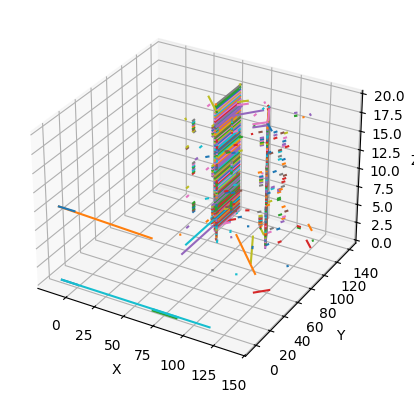

ValueError: need at least one array to concatenate

In [ ]:
import numpy as np
from stl import mesh
from scipy.spatial.transform import Rotation as R
import pandas as pd

def create_tube_segment(p1, p2, radius, segments=12):
    """
    Create vertices and faces for a cylindrical tube segment between two points.

    Parameters:
        p1, p2 (np.array): The start and end points of the tube.
        radius (float): Radius of the tube.
        segments (int): Number of segments for circular cross-section.
        
    Returns:
        vertices, faces: Arrays of vertices and faces for the tube segment.
    """
    p1 = np.asarray(p1, dtype=np.float64)
    p2 = np.asarray(p2, dtype=np.float64)
    direction = p2 - p1
    length = np.linalg.norm(direction)
    direction /= length  # Normalize direction
    
    # Generate a circle in the XY plane
    theta = np.linspace(0, 2 * np.pi, segments, endpoint=False)
    circle = np.stack((radius * np.cos(theta), radius * np.sin(theta), np.zeros_like(theta)), axis=-1)
    
    # Rotate the circle to align with the segment direction
    axis = np.array([0, 0, 1], dtype=np.float64)
    if not np.allclose(direction, axis):
        rotation_vector = np.cross(axis, direction)
        rotation_angle = np.arccos(np.clip(np.dot(axis, direction), -1.0, 1.0))
        rotation = R.from_rotvec(rotation_angle * rotation_vector)
        circle = rotation.apply(circle)
    
    # Translate circles to p1 and p2
    circle_p1 = circle + p1
    circle_p2 = circle + p2
    
    # Create faces connecting the circles
    vertices = np.vstack((circle_p1, circle_p2))
    faces = []
    for i in range(segments):
        next_i = (i + 1) % segments
        # Two triangles per segment side
        faces.append([i, next_i, segments + i])
        faces.append([segments + i, next_i, segments + next_i])
    faces = np.array(faces)

    return vertices, faces

def create_extruded_path(df, radius=0.5, segments=12):
    """
    Create vertices and faces for the full extrusion path by segment.

    Parameters:
        df (pd.DataFrame): Dataframe containing X, Y, Z coordinates, extrusion flag, and segment_id.
        radius (float): Radius of the tube.
        segments (int): Number of segments for circular cross-section.
        
    Returns:
        all_vertices, all_faces: Combined arrays of vertices and faces for the entire path.
    """
    all_vertices = []
    all_faces = []
    vertex_offset = 0

    # Group by segment_id to create separate segments
    for segment_id, segment_df in df[df['E'] == True].groupby('segment_id'):
        segment_df = segment_df.reset_index(drop=True)
        
        for i in range(len(segment_df) - 1):
            p1 = segment_df.loc[i, ['X', 'Y', 'Z']].values
            p2 = segment_df.loc[i + 1, ['X', 'Y', 'Z']].values
            
            # Get vertices and faces for this segment
            vertices, faces = create_tube_segment(p1, p2, radius, segments)
            
            # Offset faces to account for the vertices already added
            faces += vertex_offset
            vertex_offset += len(vertices)

            # Add to the global list
            all_vertices.append(vertices)
            all_faces.append(faces)
    
    # Combine all vertices and faces into single arrays
    all_vertices = np.vstack(all_vertices)
    all_faces = np.vstack(all_faces)
    
    return all_vertices, all_faces

def export_stl(vertices, faces, filename):
    """
    Export the combined vertices and faces as an STL file.

    Parameters:
        vertices (np.array): Array of vertices for the mesh.
        faces (np.array): Array of faces for the mesh.
        filename (str): Filename for the STL file.
    """
    # Create the mesh with numpy-stl
    stl_mesh = mesh.Mesh(np.zeros(faces.shape[0], dtype=mesh.Mesh.dtype))
    for i, face in enumerate(faces):
        for j in range(3):
            stl_mesh.vectors[i][j] = vertices[face[j], :]
    
    # Save the mesh
    stl_mesh.save(filename)
    print(f"STL file saved as {filename}")

# Assuming df is the DataFrame with X, Y, Z, E, and segment_id
# Generate STL for extrusion-only path by segments
all_vertices, all_faces = create_extruded_path(df, radius=0.5, segments=12)
export_stl(all_vertices, all_faces, "output_trace_path_no_travel.stl")
print("STL file created: output_trace_path_no_travel.stl")
